# Exercise 1: Using logistic regression

## Import the dataset

In [29]:
# Install required packages if using jupyterhub
# %pip install -r ../requirements.txt

For this exercise, we're gonna look at some iron ore data to try to predict the ore deposits.

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [31]:
df = pd.read_csv('../data/iron_ore_study.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FE      3500 non-null   float64
 1   SIO2    3500 non-null   float64
 2   AL2O3   3500 non-null   float64
 3   P       3500 non-null   float64
dtypes: float64(4)
memory usage: 109.5 KB


In [33]:
df.head()

,FE,SIO2,AL2O3,P
0,58.33,1.95,2.20,0.07
1,57.53,2.45,2.62,0.08
2,57.05,2.94,3.37,0.12
3,56.43,2.95,2.91,0.09
4,57.70,2.89,2.43,0.08


First, we're gonna add a variable defining if a sample comes from an ore deposit or not. In a labelled dataset for supervised learning, this information may aleady be present, and we would be able to use it to build a model to predict whether a sample is an ore deposit. 

In [40]:
# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if all 4 conditions are True
df['is_ore'] = np.vstack([
    pd.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

This new variable *is_ore* is categorical, with two possible values: True or False.

<AxesSubplot: xlabel='is_ore', ylabel='count'>

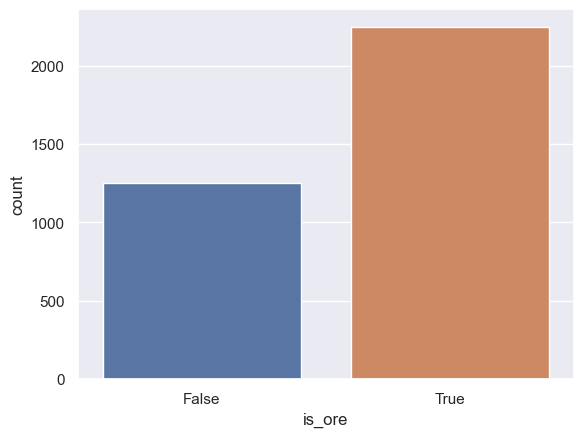

In [36]:
sns.countplot(x='is_ore', data=df)

Let's have a look at our split on the data.

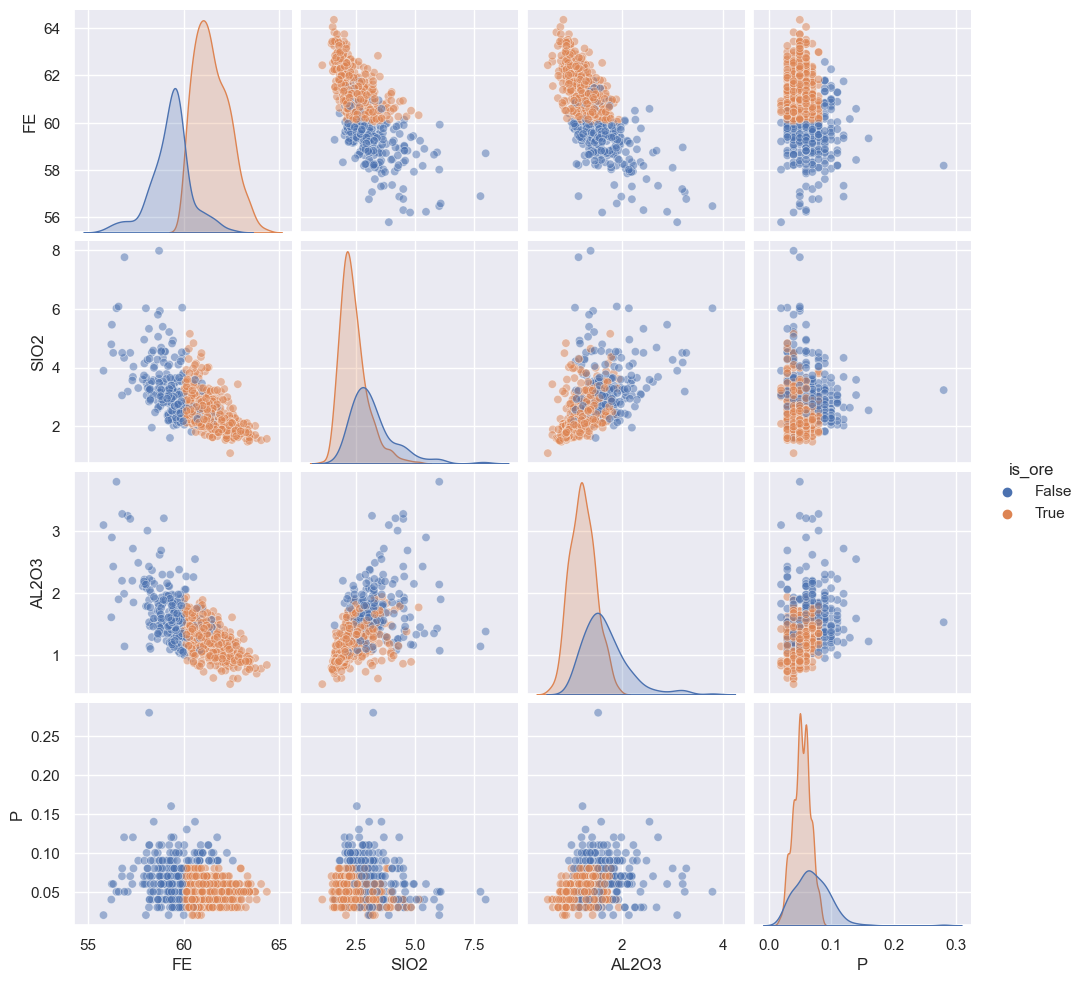

In [37]:
sns.pairplot(df.iloc[::5], hue='is_ore', plot_kws={'alpha': 0.5})

We can also plot the data individually while looking at the marginal distributions.

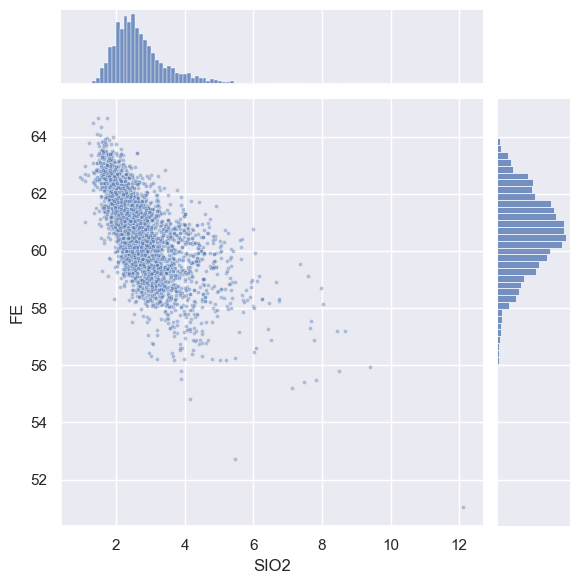

In [38]:
sns.jointplot(x='SIO2', y='FE', data=df, joint_kws={'alpha': 0.4, 'marker': '.'})

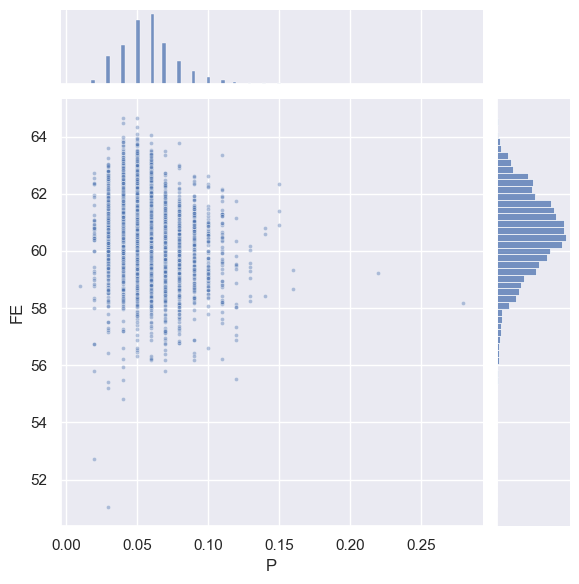

In [39]:
sns.jointplot(x='P', y='FE', data=df, joint_kws={'alpha': 0.4, 'marker': '.'})

## Logistic regression

You can think of the logistic function as a function that takes a real number (as comes out of the linear regression) and 'squashes' it into a 0, 1 label. It's defined as

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

<AxesSubplot: xlabel='z'>

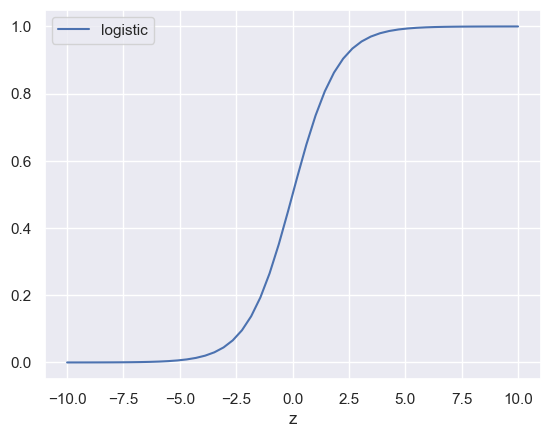

In [12]:
def logistic(z):    
    return 1 / (1 + np.exp(-z))

zs = np.linspace(-10, 10)
logistic_data = pd.DataFrame( 
    {'z': zs, 'logistic': logistic(zs)}
)
logistic_data.plot('z', 'logistic')

If we can generate a linear model fit with one parameter - call it $f$:

$$
z = f(x) = a + b x
$$

where $a$ is the intercept, $b$ the coefficient and $x$ is the input features. Then we get label predictions

$$
\mathrm{label} = g(f(x)) > threshold
$$

Another way of looking at this, if P is the probabiliy of ore
$$
P = \frac{1}{1+ e^{-z}} \\
z = a + bx
$$
Rearrange to get,
$$
log(\frac{P}{1 - P}) = a + bx
$$

LHS is called 'Log-Odds' and so, we're modelling the log-odds with a linear model.

## Problem

Let's pretend we have a crappy sensor which only measures Al. Can we still make good predictions of ore/not ore using just this feature?

We should look at transforming our aluminium data so that we go from (0, inf) -> (-inf, inf). We'll do this in a hacky sense by using a log function but we should really use a log-ratio transform here!

/var/folders/mb/6nly2rd17jdg65dg27d237lw0000gn/T/ipykernel_96591/15388563.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['AL2O3'])


<AxesSubplot: xlabel='AL2O3', ylabel='Density'>

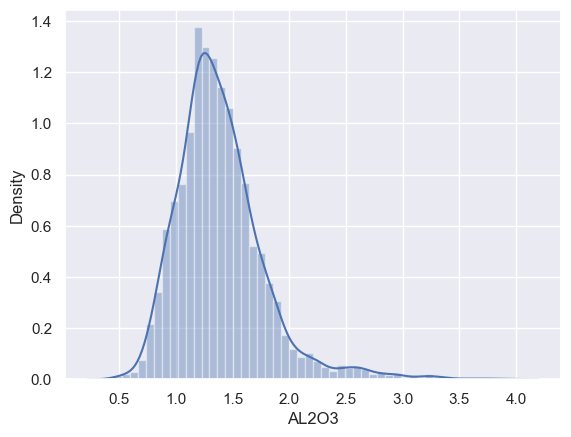

In [13]:
sns.distplot(df['AL2O3'])

/var/folders/mb/6nly2rd17jdg65dg27d237lw0000gn/T/ipykernel_96591/427548316.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['AL2O3']))


<AxesSubplot: xlabel='AL2O3', ylabel='Density'>

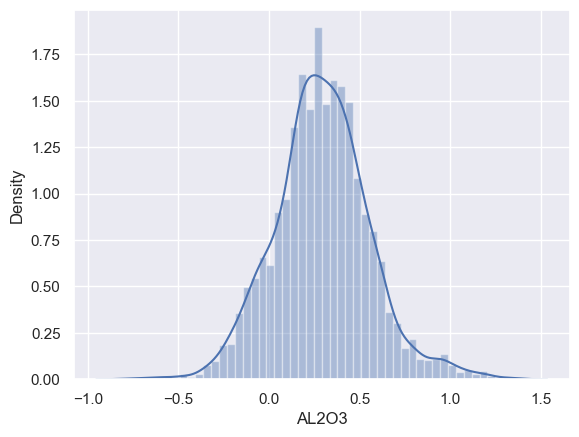

In [14]:
sns.distplot(np.log(df['AL2O3']))

We'll do this using a scikit-learn pipeline - this lets us chain transformations and predictions into one object which makes life a lot easier. Using a pipeline also means we can treat our pipeline object as a scikit-learn model, and fit and predict in similar ways, `regressor.fit(X,y)` and `regressor.predict(X)`

In [15]:
from sklearn import preprocessing, pipeline, linear_model

# Make up our pipeline where we transform the aluminium first to make it more gaussian!
regressor = pipeline.Pipeline([
    ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
    ('model', linear_model.LogisticRegression())
])

Next we map the data into the `y ~ f(X)` format that scikit-learn wants

In [16]:
X = df[['AL2O3']]
y = df['is_ore']

Now fitting the model is as simple as

In [17]:
regressor.fit(X, y)

Pipeline(steps=[('transform',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('model', LogisticRegression())])

Once we've fitted the model we can make predictions straight away

In [18]:
predict_df = pd.DataFrame(
    {'test_al2o3_values': [0.5, 1, 2, 3, 4]} # Are these values ore?
)  
regressor.predict(predict_df)

/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_al2o3_values
Feature names seen at fit time, yet now missing:
- AL2O3

  warnings.warn(message, FutureWarning)


array([ True,  True, False, False, False])

To see what's going on in a bit more depth, we can pull the coefficients out of the scikit-learn pipeline

In [19]:
model = regressor.named_steps.model
model.intercept_, model.coef_

(array([2.47913291]), array([[-5.76310306]]))

And we can evaulate our logistic function for our test values. `predict_proba()` comes in handy when we're not just interested in the prediction of ore/not-ore, but also how likely is it to be ore/not-ore. High probablility values indicates a strong evidence in the data supporting the model prediction.

In [20]:
regressor.predict_proba(predict_df)

/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_al2o3_values
Feature names seen at fit time, yet now missing:
- AL2O3

  warnings.warn(message, FutureWarning)


array([[0.00154095, 0.99845905],
       [0.07733405, 0.92266595],
       [0.81988163, 0.18011837],
       [0.97921018, 0.02078982],
       [0.9959711 , 0.0040289 ]])

With these in hand lets generate some plots

/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_al2o3_values
Feature names seen at fit time, yet now missing:
- AL2O3

  warnings.warn(message, FutureWarning)
/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_al2o3_values
Feature names seen at fit time, yet now missing:
- AL2O3

  warnings.warn(message, FutureWarning)


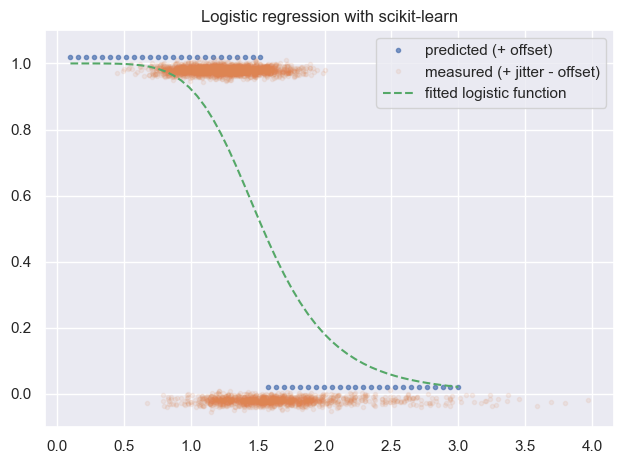

In [22]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = pd.DataFrame(
    {'test_al2o3_values': np.linspace(0.1, 3)}
)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = regressor.predict(al_compositions)
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, regressor.predict_proba(al_compositions)[:, 1], '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with scikit-learn')
f.tight_layout()

The scatterplot data points (in orange) show the original AL2O3 data, ranging between 0 to 4. Some of these samples is ore (plotted at y axis = 1) and some are not ore (plotted at y axis = 0). The logistic model fit then tells us low values of AL2O3 (AL2O3 approx less than 1.5) are predicted to be ore, and high values of AL2O3 (> 1.5) are predicted to be not ore. This model is not always accurate, but does provide the right predictions for very low and very high values of AL3O3. 

## Optional: You can also try this using one of the other variables!

In [25]:
from sklearn import preprocessing, pipeline, linear_model

# Make up our model or pipeline
regressor = pipeline.Pipeline([
    ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
    ('model', linear_model.LogisticRegression())
]) 

# Set up inputs
X = df[['FE']]
y = df['is_ore']

# Fit the model
regressor.fit(X, y)

Pipeline(steps=[('transform',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('model', LogisticRegression())])

/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_fe_values
Feature names seen at fit time, yet now missing:
- FE

  warnings.warn(message, FutureWarning)
/Users/yingyap/projects/Core Skills/Oct 2022 /05-simple-predictions/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test_fe_values
Feature names seen at fit time, yet now missing:
- FE

  warnings.warn(message, FutureWarning)


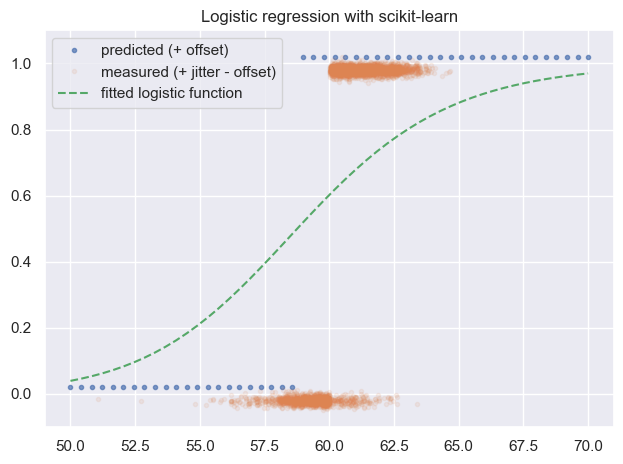

In [29]:
f, ax = plt.subplots(1, 1)

# Some iron values to predict from
fe_compositions = pd.DataFrame(
    {'test_fe_values': np.linspace(50, 70)}
)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = regressor.predict(fe_compositions)
ax.plot(fe_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['FE'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(fe_compositions, regressor.predict_proba(fe_compositions)[:, 1], '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with scikit-learn')
f.tight_layout()

Visually, FE is a better predictor than AL2O3! But how do we quantify this?

## Measuring model performance

Looking at the previous plot, it feels like we won't get everything right! How can we get a feeling for the model performance? What are some of the issues that we might need to take into account?

Splitting our data between a training and a test set is a good way to start validating our model.

In [41]:
from sklearn.model_selection import train_test_split

X = df[['AL2O3']]
y = df['is_ore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Now we can train on just the training set, predict on the test set and see how we do!

In [42]:
regressor.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('model', LogisticRegression())])

In [43]:
y_predict = regressor.predict(X_test)

In [44]:
results = pd.DataFrame({
    'AL2O3': X_test['AL2O3'],
    'is_ore_actual': y_test,
    'is_ore_predicted': y_predict,
    'count': 1
})
results.head()

,AL2O3,is_ore_actual,is_ore_predicted,count
3440,1.94,False,False,1
1851,1.29,True,True,1
3096,1.60,False,False,1
1545,1.20,True,True,1
987,1.21,True,True,1


Now we can see the number of false positives and false negatives using pivot_table from last week (rows are actual T/F and columns are predicted T/F)

In [45]:
confusion = results.pivot_table(values='count', index='is_ore_actual', columns='is_ore_predicted', aggfunc='sum')
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,234,183
True,74,664


and plot with sns

<AxesSubplot: xlabel='is_ore_predicted', ylabel='is_ore_actual'>

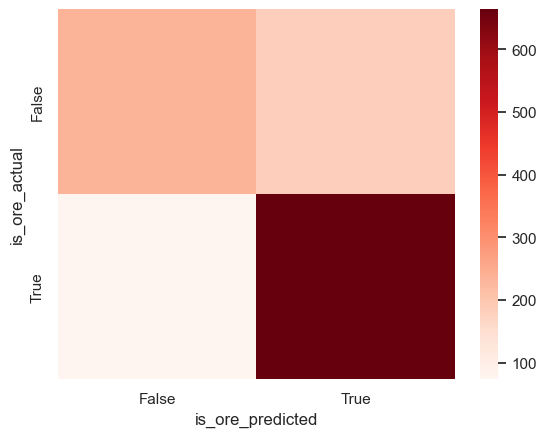

In [46]:
sns.heatmap(confusion, cmap='Reds')

Alternatively we can unstack the array into true and false negatives and positives

In [47]:
confusion.unstack()

is_ore_predicted  is_ore_actual
False             False            234
                  True              74
True              False            183
                  True             664
dtype: int64

And we can convert these values to fractions of the total

In [48]:
true_neg, false_neg, false_pos, true_pos = confusion.unstack()/confusion.unstack().sum()
true_neg, false_neg, false_pos, true_pos

(0.2025974025974026,
 0.06406926406926407,
 0.15844155844155844,
 0.5748917748917749)

- True positives - Model predicts true, and model is true/accurate
- False positives - Model predicts true, and model is false/inaccurate
- True negatives - Model predicts false, and model is true/accurate
- False negatives - Model predicts false, and model is false/inaccurate

When are true positives and false positives important?

## Threshold

We haven't done anything with the threshold yet. By default scikit-learn uses 0.5 in *predict*, but how should we pick the value for this?

We've already got a confusion matrix - we can take the ratio of the true_positive vs the false_positive rates and compare the two 

In [51]:
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,234,183
True,74,664


In [52]:
correct = np.diag(confusion)
incorrect = np.diag(np.roll(confusion, 1, axis=1))
correct, incorrect

(array([234, 664]), array([183,  74]))

`total correct` is the number of samples the model predicted an accurate category, `total_incorrect` is the number of samples the model predicted incorrectly.

In [53]:
total_correct = correct.sum()
total_incorrect = incorrect.sum()
total_correct, total_incorrect

(898, 257)

By choosing a different probability threshold, the `total_correct` and `total_incorrect` will change. So will the true positives, true negatives, false positives and false negatives. 

Let's try changing the threshold, and plotting the results. We need a way of adjusting the class weights in the model. Scikit-learn doesn't let you specify a threshold directly but we can calculate it ourselves.

In [54]:
def fit_with_class_threshold(threshold):
    "Fit a logistic regression to get an ROC value for a given threshold"
    # Transform our threshold into class weights
    class_weights = {True: threshold, False: 1 - threshold}
    
    # Make a regressor
    regressor = pipeline.Pipeline([
        ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
        ('model', linear_model.LogisticRegression(class_weight=class_weights))
    ])
    
    # Fit it
    regressor.fit(X_train, y_train)
    
    # Make some predictions, see how we did
    results = pd.DataFrame({
        'AL2O3': X_test['AL2O3'],
        'is_ore_actual': y_test,
        'is_ore_predicted': regressor.predict(X_test),
        'count': 1
    })
    confusion = results.pivot_table(
        values='count', 
        index='is_ore_actual', 
        columns='is_ore_predicted', 
        aggfunc='sum').fillna(0)
    true_neg, false_neg, false_pos, true_pos = confusion.unstack()
    correct = np.diag(confusion)
    incorrect = np.diag(np.roll(confusion, 1, axis=1))
    
    # Return results as a dictionary
    return {
        'threshold': threshold,
        'total_correct': correct.sum(), 
        'total_incorrect': incorrect.sum(), 
        'true_negative': true_neg,
        'false_negative': false_neg,
        'true_positive': true_pos,
        'false_positive': false_pos,
        'accuracy': correct.sum()/(correct.sum() + incorrect.sum()),
        'precision': true_pos/(true_pos + false_pos),
        'recall': true_pos/(true_pos + false_neg)
    } 

Now we can generate results using our metric

In [55]:
fit_with_class_threshold(0.1)

{'threshold': 0.1,
 'total_correct': 529,
 'total_incorrect': 626,
 'true_negative': 405,
 'false_negative': 614,
 'true_positive': 124,
 'false_positive': 12,
 'accuracy': 0.45800865800865803,
 'precision': 0.9117647058823529,
 'recall': 0.16802168021680217}

In [56]:
fit_with_class_threshold(0.9)

{'threshold': 0.9,
 'total_correct': 776.0,
 'total_incorrect': 379.0,
 'true_negative': 38.0,
 'false_negative': 0.0,
 'true_positive': 738.0,
 'false_positive': 379.0,
 'accuracy': 0.6718614718614718,
 'precision': 0.6606982990152194,
 'recall': 1.0}

Now we can iterate over all our thresholds and see what does the best

In [59]:
results = pd.DataFrame.from_records(
    [fit_with_class_threshold(t) for t in np.linspace(0.1, 0.9)],
    index='threshold'
)
results.head()

,total_correct,total_incorrect,true_negative,false_negative,true_positive,false_positive,accuracy,precision,recall
threshold,,,,,,,,,
0.100000,529.0,626.0,405.0,614.0,124.0,12.0,0.458009,0.911765,0.168022
0.116327,553.0,602.0,402.0,587.0,151.0,15.0,0.478788,0.909639,0.204607
0.132653,582.0,573.0,398.0,554.0,184.0,19.0,0.503896,0.906404,0.249322
0.148980,597.0,558.0,389.0,530.0,208.0,28.0,0.516883,0.881356,0.281843
0.165306,608.0,547.0,385.0,515.0,223.0,32.0,0.526407,0.874510,0.302168


A high accuracy means few labels were incorrectly predicted. It is not always a good indicator of the quality of a binary classification since it doesn't account for any imbalance between the categories.

That's why precision and recall are always measured as well. A high precision means a low false positive rate, a high recall means a low false negative rate. As scikit-learn [puts it](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html):

"A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the [test] labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the [test] labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly."

<AxesSubplot: xlabel='threshold'>

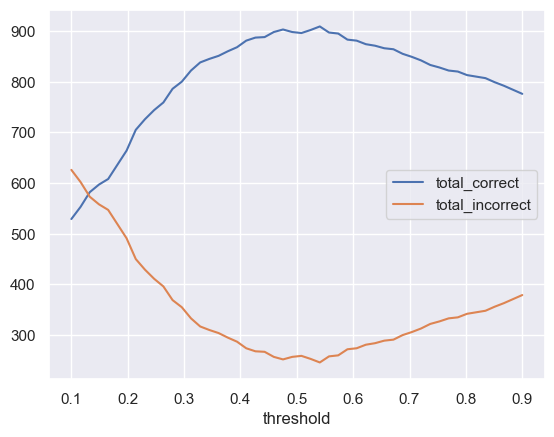

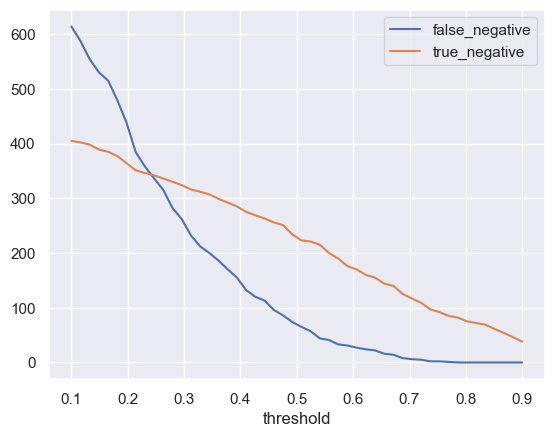

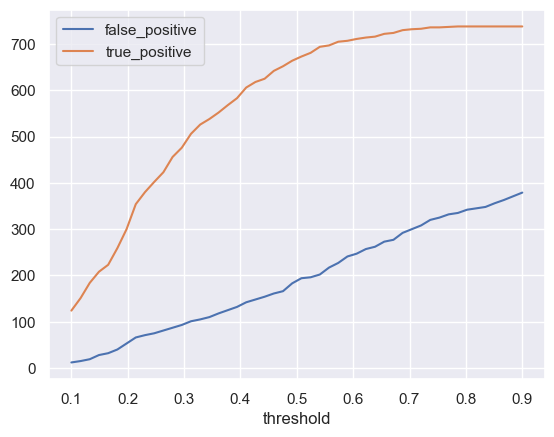

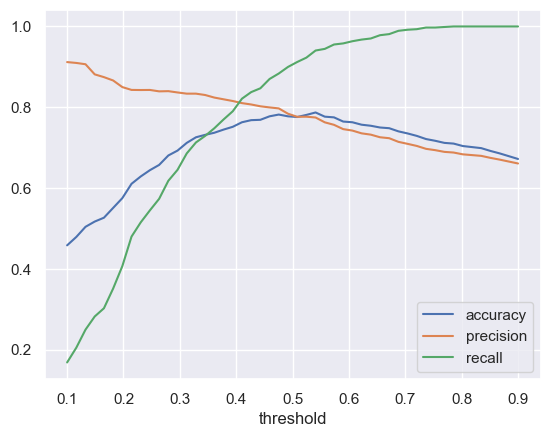

In [60]:
results.plot(y=['total_correct', 'total_incorrect'])
results.plot(y=['false_negative', 'true_negative'])
results.plot(y=['false_positive', 'true_positive'])
results.plot(y=['accuracy', 'precision', 'recall'])

Scikit-learn implements a lot of those metrics already, see for instance:

* [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
* [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
* [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

Another useful tool to assess the performance of a classifier is the Receiver Operating Characteristic (ROC) metric. It is a curve showing false positive rate vs. true positive rate. Ideally, the curve for the classifier should be as close as possible to the top-left corner (i.e., lots of true positive and few false positive). The diagonal line basically means a random classifier. Measuring the area below the curve turns the curve into a single value: close to 1 is better, 0.5 indicates a random classifier.

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, regressor.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

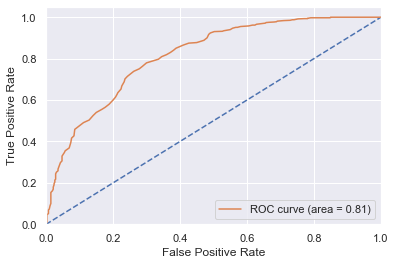

In [37]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'%roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Extension: Modelling with statsmodels

For what it's worth we can also generate these using [statsmodels](https://www.statsmodels.org/stable/index.html)

In [38]:
import statsmodels.api as sm

We have to handle preprocessing ourselves 

In [39]:
from statsmodels.tools import add_constant

def preprocess(x):
    "Our preprocessing pipeline for Al2O3"
    return add_constant(np.log(x)) # add_constant adds an intercept to the fit

Statsmodels uses stats jargon 
- endog -> endogenous variable -> y
- exog -> exogenous variable -> X

In [40]:
endog = df.is_ore
exog = preprocess(df['AL2O3'])

Fitting the model is pretty similar though

In [41]:
model = sm.Logit(endog, exog)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.492165
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_ore   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3498
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Feb 2020   Pseudo R-squ.:                  0.2453
Time:                        09:26:41   Log-Likelihood:                -1722.6
converged:                       True   LL-Null:                       -2282.3
Covariance Type:            nonrobust   LLR p-value:                1.922e-245
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5869      0.092     27.996      0.000       2.406       2.768
AL2O3         -6.0717      0.236    -25.774      0.000      -6.533      -5.610
==============================================================================
"""

Statsmodels does a bit more statistical testing/automated confidence intervals for us at the cost of having to manage crossvalidation etc ourselves. Depending on what you're trying to achieve this could be a viable way to go.

As before we can immediately make some predictions - statsmodels gives us the value of the logistic function

In [42]:
preds = model.predict(results.params, preprocess(X_test['AL2O3']))
preds

array([0.96182177, 0.77416819, 0.29318951, ..., 0.25940155, 0.35454438,
       0.77416819])

In [43]:
preds > 0.5

array([ True,  True, False, ..., False, False,  True])

and compare to scikit-learn

In [44]:
regressor.predict(X_test[['AL2O3']])

array([ True,  True, False, ..., False, False,  True])

We can also compare the logistic values get slightly different answers here - probably down to the solver used under the hood

In [45]:
print(' statsmodels:', model.predict(results.params, preprocess(X_test['AL2O3'])))
print('scikit-learn:', regressor.predict_proba(X_test[['AL2O3']])[:, 1])

 statsmodels: [0.96182177 0.77416819 0.29318951 ... 0.25940155 0.35454438 0.77416819]
scikit-learn: [0.95350482 0.76585125 0.31891446 ... 0.2860928  0.37746958 0.76585125]


We can generate the same plot again though

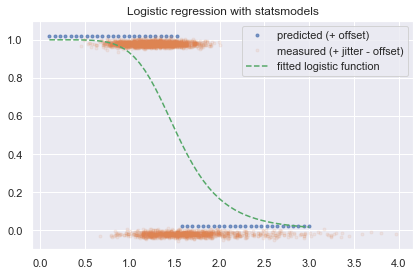

In [46]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = np.linspace(0.1, 3)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = model.predict(results.params, preprocess(al_compositions)) > 0.5
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, model.predict(results.params, preprocess(al_compositions)), '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with statsmodels')
f.tight_layout()

# Exercise 2: Importance of validation

In this exercise, we want to see the importance of splitting our dataset into a training set and a test set. To make things easier to understand, we're gonna work with synthetic data generated using NumPy.

First, we need to make our results reproducible by setting a seed.

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
np.random.seed(100)


## Step 1: Generate the synthetic data

To make things a little more interesting, we're gonna use a sinusoidal function with some random noise.

In [17]:
n_samples = 120
x = np.random.uniform(0, 1, n_samples)
noise = np.random.normal(0, 0.1, n_samples)
y = np.sin(np.pi*x) + noise

<AxesSubplot: >

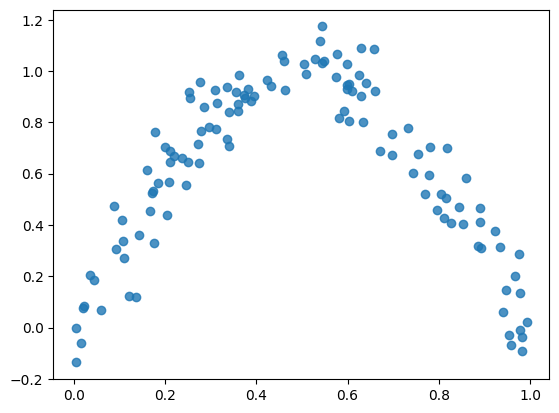

In [18]:
sns.regplot(x=x, y=y, fit_reg=False)

## Step 2: Fit a polynomial model

With a bell shape like that a simple linear model won't do, we need a polynomial model. To do that in scikit-learn, we build a pipeline combining *PolynomialFeatures*, which defines the degree of the polynomial, with *LinearRegression* to perform the actual regression.

Fill the pipeline to get a polynomial model of degree 20 (let's start high, because more degrees means a more complex model and that's always a good start, right?)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [20]:
model = make_pipeline(PolynomialFeatures(20), LinearRegression())

In [21]:
model.fit(x.reshape(-1, 1), y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=20)),
                ('linearregression', LinearRegression())])

Now let's have a look at our model.

In [22]:
x_plot = np.linspace(0, 1, 1000)
y_plot = model.predict(x_plot.reshape(-1, 1))

<AxesSubplot: >

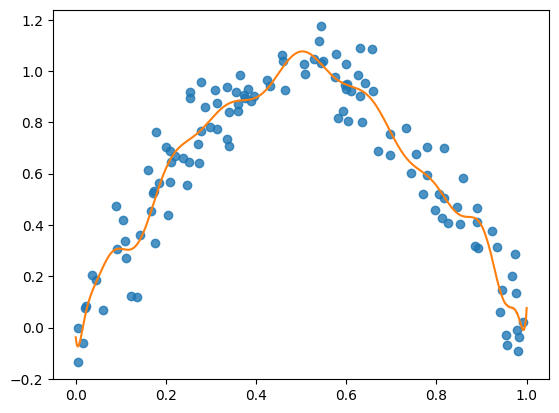

In [23]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)

And at how well it performs.

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
model.score(x.reshape(-1, 1), y)

0.9147149808494536

In [26]:
y_pred = model.predict(x.reshape(-1, 1))

In [27]:
mean_squared_error(y, y_pred)

0.009663174908300138

This model fit has too many wiggles in its attempt to fit all the data, including all the noise, or scatter. A 20 degree polynomial is too high.  This model is likely to be **over-fitting**.

## Step 3: Check a model with fewer degrees

Let's check a linear model.

In [59]:
model = LinearRegression()

In [60]:
model.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
x_plot = np.linspace(0, 1, 1000)
y_plot = model.predict(x_plot.reshape(-1, 1))

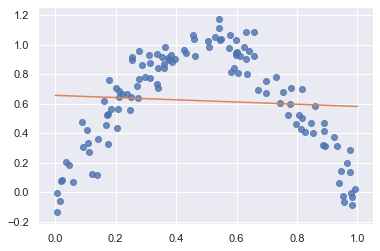

In [62]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)

And let's see how it performs.

In [63]:
model.score(x.reshape(-1, 1), y)

0.0043100242537060796

In [64]:
y_pred = model.predict(x.reshape(-1, 1))

In [65]:
mean_squared_error(y, y_pred)

0.11281613683047312

That's really bad... We're not capturing the bell shape at all, and the score and error show it clearly. The problem is that our data are clearly non-linear, and a linear model is not capable of capturing this pattern. So our model is **under-fitting**.

Let's check again with the lowest degree capable of capturing this pattern: 2.

In [66]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())

In [67]:
model.fit(x.reshape(-1, 1), y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [68]:
x_plot = np.linspace(0, 1, 1000)
y_plot = model.predict(x_plot.reshape(-1, 1))

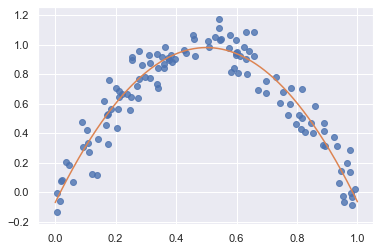

In [69]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)

And let's see how it performs.

In [70]:
model.score(x.reshape(-1, 1), y)

0.8990242373076673

In [71]:
y_pred = model.predict(x.reshape(-1, 1))

In [72]:
mean_squared_error(y, y_pred)

0.011441006475857335

That's better than the linear model, but worse than a degree of 20, so a high degree must be better!

##  Step 4: Use a test set

Actually, maybe we shouldn't train and test on the same data. Let's check the impact of that. With a test set, we should be able to see the over-fitting not just visually but also in the test results.

First, we need to split our dataset into a training and test set.

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=100)

Let's look at what happens with a degree of 20.

In [74]:
model = make_pipeline(PolynomialFeatures(20), LinearRegression())

In [75]:
model.fit(x_train.reshape(-1, 1), y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [76]:
x_plot = np.linspace(0, 1, 1000)
y_plot = model.predict(x_plot.reshape(-1, 1))

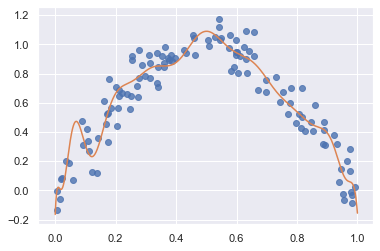

In [77]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)

In [78]:
model.score(x_test.reshape(-1, 1), y_test)

0.8632418061570847

In [79]:
y_pred = model.predict(x_test.reshape(-1, 1))

In [80]:
mean_squared_error(y_test, y_pred)

0.01921601708010387

And now with a degree of 2.

In [81]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())

In [82]:
model.fit(x_train.reshape(-1, 1), y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [83]:
x_plot = np.linspace(0, 1, 1000)
y_plot = model.predict(x_plot.reshape(-1, 1))

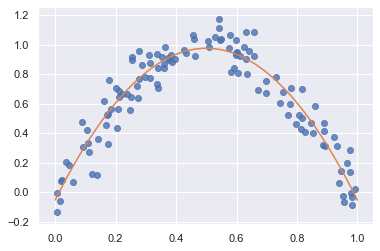

In [84]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)

In [85]:
model.score(x_test.reshape(-1, 1), y_test)

0.9474984496446641

In [86]:
y_pred = model.predict(x_test.reshape(-1, 1))

In [87]:
mean_squared_error(y_test, y_pred)

0.007377040161256369

Well, our validation metrics are better with the lower degree now... But that was only one possible splitting, and we don't have so many data, maybe testing it again will lead to different results.

Instead of doing it manually, let's use scikit-learn's cross-validation function.

In [88]:
from sklearn.model_selection import cross_val_score

In [89]:
model = make_pipeline(PolynomialFeatures(20), LinearRegression())
score = cross_val_score(model, x.reshape(-1, 1), y, scoring='neg_mean_squared_error')
-score.mean(), score.std()

(0.0390350746717936, 0.04203910552121794)

In [90]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
score = cross_val_score(model, x.reshape(-1, 1), y, scoring='neg_mean_squared_error')
-score.mean(), score.std()

(0.012091031676979775, 0.00221202579690422)

Now, a degree 2 is clearly a better choice. The problem is that a more complex model can fit more complex patterns, and it's trying to identify patterns in the noise as well. Our model with a degree of 20 is **over-fitting**.

## Step 5: Choose the right degree

The now the question become how to choose the best degree for the problem?

One easy way to identify that degree is to add the cross-validation into a loop.

In [91]:
degrees = list(range(1, 31))
scores = []

for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    score = cross_val_score(model, x.reshape(-1, 1), y, scoring='neg_mean_squared_error')
    scores.append(-score.mean())

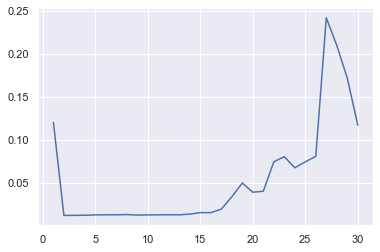

In [92]:
sns.lineplot(x=degrees, y=scores)

Now let's have a look at the degree with the smallest error.

In [93]:
degrees[np.argmin(scores)]

2

It turns out scikit-learn can look for and give us directly the best model. To do so, we just need to perform a grid search over the parameter *degree* of our pipeline. For each value of degree we want to test, scikit-learn is gonna perform cross-validations with a given score, and use that to pick the best model.

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [95]:
model = Pipeline(steps=[('polynomial', PolynomialFeatures()),
                        ('regression', LinearRegression())])
param_grid = [{'polynomial__degree': degrees}]
scoring = 'neg_mean_squared_error'

In [96]:
search = GridSearchCV(model, param_grid, scoring=scoring)

In [97]:
search.fit(x.reshape(-1, 1), y)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomial',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('regression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'polynomial__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                        

Let's check that the search led to the right degree.

In [98]:
search.best_params_

{'polynomial__degree': 2}

And we can directly access the model to make some predictions.

In [99]:
x_plot = np.linspace(0, 1, 1000)
y_plot = search.best_estimator_.predict(x_plot.reshape(-1, 1))

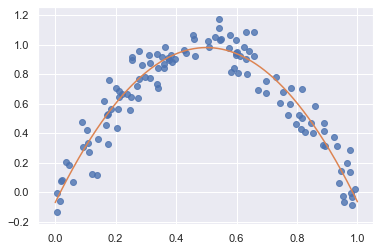

In [100]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
sns.lineplot(x=x_plot, y=y_plot, ax=ax)